In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time


#define plotting style that I like
style.use('fivethirtyeight')

#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Total cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % (day, hour, minutes, seconds) )
    print('')
    
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)

def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K_experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K_experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)

In [2]:
def new_phenom_rename(df, observable):
    df.rename(columns={'t_lab':'energy'}, inplace=True)
    df.rename(columns={'observable':'experimental_value'}, inplace=True)
    df.rename(columns={'error':'sigma'}, inplace=True)
    df['observable']=observable
    
def combine_data_new():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #new phenomenological data
    sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
    sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
    sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
    sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')
    new_phenom_rename(sgt_small,'   SGT ')
    new_phenom_rename(sgtt_small,'   SGTT')
    new_phenom_rename(sgt_large,'   SGT ')
    new_phenom_rename(sgtt_large,'   SGTT')
    new_data = pd.concat([sgt_small, sgt_large, sgtt_small, sgtt_large])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data, new_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def combine_data_old():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def gauss_factor(combined_data, mu, sigma):
    ###create Gaussian factor 
    #Gaussian distribution
    combined_data['Gauss_factor'] = np.random.normal(mu, sigma, len(combined_data.energy))
    combined_data['Gauss_exp'] = combined_data.apply(lambda row: ((row.K_experimental_value) + (row.K_sigma*row.Gauss_factor)), axis=1)
    #remove unecessary columns
    combined_data = combined_data.drop(columns=['K_experimental_value', 'K_sigma', 'experimental_value', 'k', 'sigma', 'Gauss_factor'])
    return combined_data

Text(0.5, 1.0, 'Neutron-Proton $\\Delta \\sigma_T$')

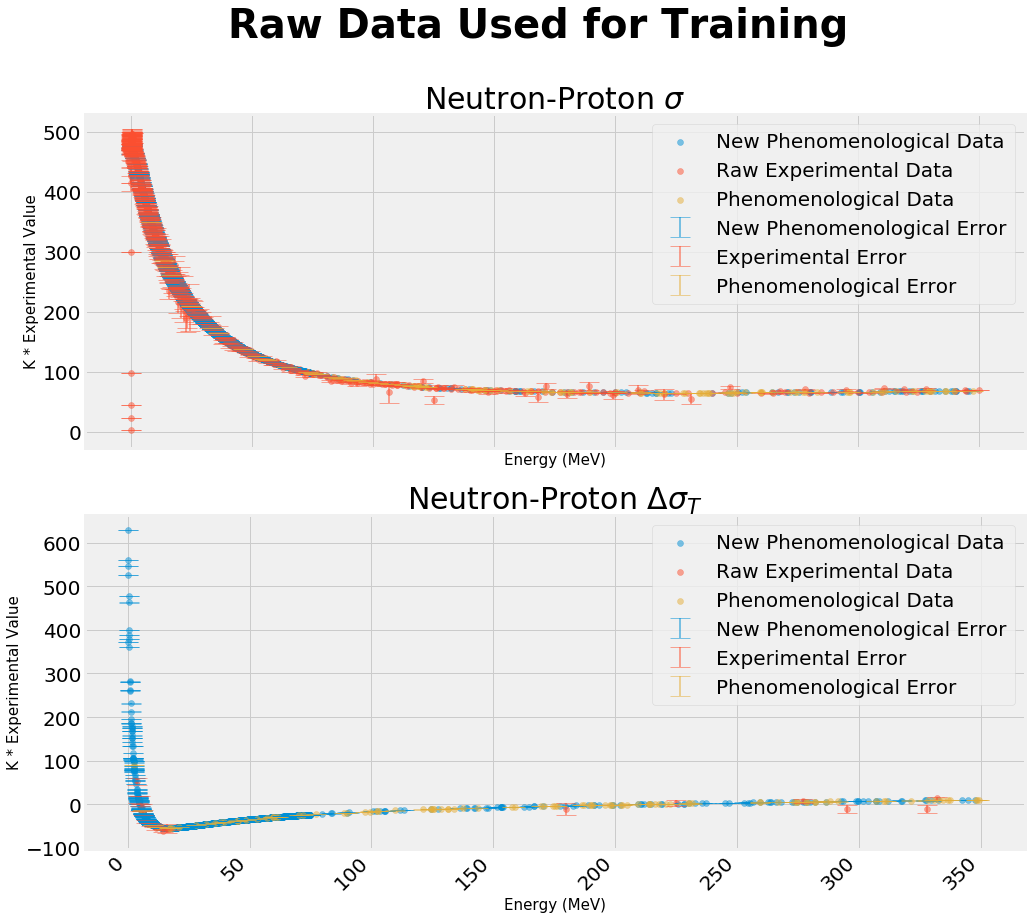

In [33]:
#organize experimental and phenomenological data for plotting
#read files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')

new_phenom_rename(sgt_small,'   SGT ')
new_phenom_rename(sgtt_small,'   SGTT')
new_phenom_rename(sgt_large,'   SGT ')
new_phenom_rename(sgtt_large,'   SGTT')

new_sgt = pd.concat([sgt_small, sgt_large], sort=True)
new_sgtt = pd.concat([sgtt_small, sgtt_large], sort=True)
#add k columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)
change_np(random_sgt)
change_np(random_sgtt)
change_np(new_sgt)
change_np(new_sgtt)
#error bar arrays
rand_err_sgt=random_sgt['K_sigma'].tolist()
rand_err_sgtt=random_sgtt['K_sigma'].tolist()
exp_err_sgt=np_sgt['K_sigma'].tolist()
exp_err_sgtt=np_sgtt['K_sigma'].tolist()
new_err_sgt=new_sgt['K_sigma'].tolist()
new_err_sgtt=new_sgtt['K_sigma'].tolist()


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)
fig.suptitle('Raw Data Used for Training', fontsize=40, fontweight='bold')

###plot 1

ax1.scatter(new_sgt['energy'], new_sgt['K_experimental_value'], alpha=0.5, label='New Phenomenological Data')
ax1.errorbar(new_sgt['energy'], new_sgt['K_experimental_value'], yerr=new_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='New Phenomenological Error')

ax1.scatter(np_sgt['energy'], np_sgt['K_experimental_value'], alpha=0.5, label='Raw Experimental Data')
ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax1.scatter(random_sgt['energy'], random_sgt['K_experimental_value'], alpha=0.5, label='Phenomenological Data')
ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=15); ax1.set_ylabel('K * Experimental Value', fontsize=15)
ax1.legend(loc='best', fontsize=20); ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)

###plot 2

ax2.scatter(new_sgtt['energy'], new_sgtt['K_experimental_value'], alpha=0.5, label='New Phenomenological Data')
ax2.errorbar(new_sgtt['energy'], new_sgtt['K_experimental_value'], yerr=new_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='New Phenomenological Error')

ax2.scatter(np_sgtt['energy'], np_sgtt['K_experimental_value'], alpha=0.5, label='Raw Experimental Data')
ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax2.scatter(random_sgtt['energy'], random_sgtt['K_experimental_value'], alpha=0.5, label='Phenomenological Data')
ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=15); ax2.set_ylabel('K * Experimental Value', fontsize=15)
ax2.legend(loc='best', fontsize=20); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

In [27]:
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
###  PARAMETERS TO BE CHANGED ARE ALL IN THIS CELL  ###
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################

#define number of times to make predictions with different gaussian factor
n_max=100

#define interval step size for predictions 
###MUST BE INTEGER >=1 AND FACTOR OF 350
interval_size = 10 #MeV  

#define number of trees used in random forest 
num_trees=1000

#define test size
test_data_size = 0.25 # % of total amount of data

Predictions computed with n = 1 - 25
Predictions computed with n = 26 - 50
Predictions computed with n = 51 - 75
Predictions computed with n = 76 - 100

Calculations complete.
Predictions computed with 100 iterations.

Total cell runtime: 0.0 days, 0.0 hours, 5.0 minutes, 45.955156087875366 seconds



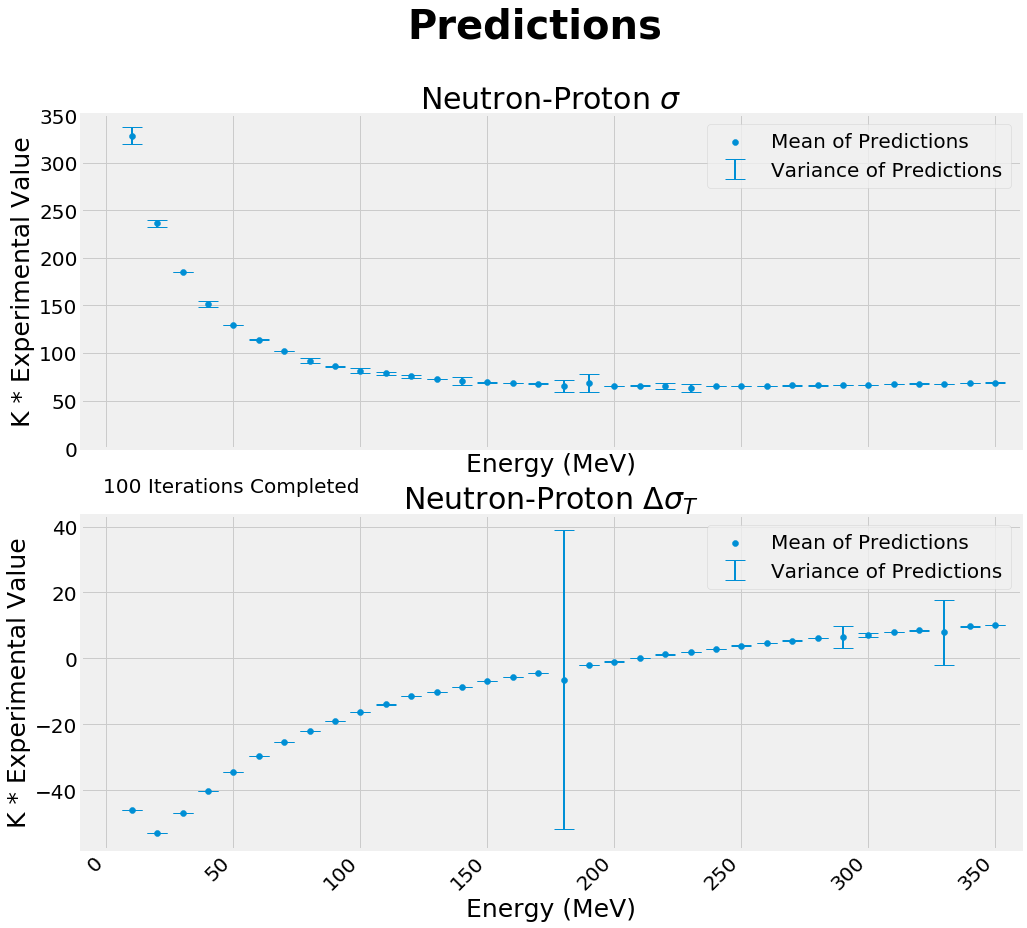

In [28]:
#start timer
gauss_time=time.time()

#define interval specifications for prediction arrays
E_max=350
num_intervals = E_max/interval_size
E_index = list(range(interval_size, E_max + int(interval_size), interval_size)) ###this will be index of dataframe

df_SGT=pd.DataFrame({'Energy': E_index})
df_SGTT=pd.DataFrame({'Energy': E_index})


for n in range(1,n_max+1):
    ###create combined dataframe
    combined_data=combine_data_new()
    #combined_data=combine_data_old()
    ###create Gaussian factor 
    combined_data=gauss_factor(combined_data, 0, 1)

    ###train
    #One-hot encode
    features = pd.get_dummies(combined_data)
    # Labels are the values we want to predict
    labels = np.array(features['Gauss_exp'])
    # Remove the labels from the features
    features = features.drop('Gauss_exp', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_data_size)
    rf = RandomForestRegressor(n_estimators= num_trees)
    # Train the model on training data
    rf.fit(train_features, train_labels);

    ###make predictions 
    #construct testing arrays
    E_SGT = []
    E_SGTT = []
    E = list(range(interval_size, E_max + int(interval_size), interval_size))
    for value in E:
        E_SGT.append([value, 1, 0])
        E_SGTT.append([value, 0, 1])
    #predict
    #SGT
    SGT_predictions = rf.predict(E_SGT)
    #SGTT
    SGTT_predictions = rf.predict(E_SGTT)
    
    #add column to dataframes
    df_SGT["SGT_Preds_%s"%('%.0f'%n)] = SGT_predictions
    df_SGTT["SGTT_Preds_%s"%('%.0f'%n)] = SGTT_predictions
    
    #print completed message
    if (n_max <= 14):
        print("Predictions computed with n = %s "%(n))
    elif (n_max > 14) and (n_max <= 49): 
        if (n%5 == 0):
            print('Predictions computed with n = %s - %s' %(int(n-4), n) )
    elif (n_max > 49) and (n_max <=99): 
        if (n%10 == 0):
            print('Predictions computed with n = %s - %s' %(int(n-9), n) )
    elif (n_max > 99): 
        if (n%25 == 0):
            print('Predictions computed with n = %s - %s' %(int(n-24), n) )
    if (n==n_max):
        print("")
        print("Calculations complete.")
        print("Predictions computed with %s iterations." %(n) )

#predictions array     
df_SGT = df_SGT.drop("Energy", axis=1)
df_SGT['Prediction Mean'] = df_SGT.mean(axis=1)
df_SGT['Prediction Variance'] = df_SGT.var(axis=1)
df_SGTT = df_SGTT.drop("Energy", axis=1)
df_SGTT['Prediction Mean'] = df_SGTT.mean(axis=1)
df_SGTT['Prediction Variance'] = df_SGTT.var(axis=1)

#plot 
#figure specs
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)
fig.suptitle('Predictions', fontsize=40, fontweight='bold')



#plot 1 - SGT
ax1.scatter(E, df_SGT['Prediction Mean'], label='Mean of Predictions')
ax1.errorbar(E, df_SGT['Prediction Mean'], yerr=df_SGT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')

ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=25)
ax1.set_xlim([-10,360])
ax1.set_ylim(bottom=0)
ax1.set_ylabel('K * Experimental Value', fontsize=25)
ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)


ax1.text(0.1, 0.53, "%s Iterations Completed"% (n_max), fontsize=20, transform=plt.gcf().transFigure)

#plot 2 - SGTT
ax2.scatter(E, df_SGTT['Prediction Mean'], label='Mean of Predictions')
ax2.errorbar(E, df_SGTT['Prediction Mean'], yerr=df_SGTT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')

ax2.tick_params(axis="y", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=25)
ax2.set_xlim([-10,360])
ax2.set_ylabel('K * Experimental Value', fontsize=25)
ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

#save figures
plt.savefig('Plots/predictions_with_gauss.pdf', format='pdf', bboxinches='tight', transparent=True)

#print elapsed time
timer(gauss_time)

In [29]:
df_SGT['Energy']=E
df_SGT.set_index("Energy", inplace = True)
df_SGT

,SGT_Preds_1,SGT_Preds_2,SGT_Preds_3,SGT_Preds_4,SGT_Preds_5,SGT_Preds_6,SGT_Preds_7,SGT_Preds_8,SGT_Preds_9,SGT_Preds_10,...,SGT_Preds_93,SGT_Preds_94,SGT_Preds_95,SGT_Preds_96,SGT_Preds_97,SGT_Preds_98,SGT_Preds_99,SGT_Preds_100,Prediction Mean,Prediction Variance
Energy,,,,,,,,,,,,,,,,,,,,,
10,330.637028,331.412191,330.780676,322.968405,327.643621,323.950576,327.207537,329.033269,323.703062,326.597039,...,332.205592,326.741456,329.293981,330.789427,326.246489,329.141395,326.871144,327.600750,328.675422,8.478503
20,234.682695,236.462048,237.407978,237.667498,237.513439,237.850238,235.061175,237.805907,234.959660,236.874051,...,235.043464,237.130959,235.657074,236.581104,236.638561,237.143192,237.803989,238.192900,236.456798,3.721363
30,185.540097,185.477833,185.799457,185.475117,185.551853,185.510852,185.570578,185.590352,185.456926,185.488187,...,185.484673,185.648699,185.550472,185.443297,185.496134,185.445765,185.575189,185.486889,185.512120,0.011044
40,152.679648,152.404676,154.968110,152.243586,151.671998,152.299680,150.130608,148.820564,147.500340,152.323348,...,151.142377,151.123740,152.291956,152.209480,149.277071,153.258277,148.165145,151.353068,151.806950,3.006699
50,129.757633,129.880394,129.962355,129.879555,129.800993,129.871776,129.872699,129.886375,129.849261,130.056110,...,129.794206,129.996315,129.853401,130.056243,129.851354,129.817771,129.956717,129.870294,129.879384,0.008081
60,114.165694,114.255723,113.855035,114.673473,114.511944,114.981549,113.256992,113.971860,115.020093,113.870727,...,114.531548,114.795529,114.813709,114.453865,112.973049,113.883572,113.924614,115.139098,114.143511,0.186958
70,102.404388,102.283583,102.329516,102.415180,102.384667,102.169379,102.208216,102.388231,102.366358,102.315167,...,102.216998,102.259493,102.378179,102.241858,102.334613,102.340206,102.271294,102.348207,102.330172,0.003804
80,92.922239,89.933025,92.339074,90.110770,91.044311,92.619672,92.411767,92.154116,93.459103,91.099526,...,91.418311,91.906711,92.699764,93.759999,90.211281,93.319736,92.986107,88.505384,91.900727,2.339566
90,85.812813,89.191960,86.730479,85.342054,85.883000,86.178014,86.524186,86.079377,85.433272,86.413716,...,86.040102,85.749383,84.541169,86.411506,84.670596,85.694696,85.725154,86.685911,86.161423,0.588386


In [30]:
df_SGTT['Energy']=E
df_SGTT.set_index("Energy", inplace = True)
df_SGTT

,SGTT_Preds_1,SGTT_Preds_2,SGTT_Preds_3,SGTT_Preds_4,SGTT_Preds_5,SGTT_Preds_6,SGTT_Preds_7,SGTT_Preds_8,SGTT_Preds_9,SGTT_Preds_10,...,SGTT_Preds_93,SGTT_Preds_94,SGTT_Preds_95,SGTT_Preds_96,SGTT_Preds_97,SGTT_Preds_98,SGTT_Preds_99,SGTT_Preds_100,Prediction Mean,Prediction Variance
Energy,,,,,,,,,,,,,,,,,,,,,
10,-46.189849,-46.029213,-45.933999,-45.857941,-46.018779,-46.257639,-45.876403,-45.762880,-45.913619,-45.976396,...,-45.951747,-45.847181,-45.918152,-45.915569,-46.008892,-45.850137,-46.082706,-46.062882,-45.974120,0.028558
20,-53.247099,-53.233516,-52.871487,-53.330121,-53.100836,-53.189635,-52.972771,-53.117675,-53.154693,-53.094953,...,-53.036955,-53.334798,-52.903177,-52.971098,-53.103272,-53.071670,-53.157519,-53.025145,-53.138017,0.025780
30,-46.812228,-47.030822,-46.776574,-46.881705,-47.187054,-46.916638,-46.721531,-46.808532,-46.952214,-47.199955,...,-47.085109,-46.977651,-46.808788,-46.867119,-47.023586,-46.824527,-47.132780,-47.072714,-46.913014,0.026668
40,-40.049062,-40.378984,-40.099421,-40.141345,-40.368201,-40.279367,-40.125930,-40.330488,-40.287365,-40.098693,...,-40.105484,-40.820089,-40.298973,-40.161284,-40.067938,-40.119070,-40.001042,-40.444284,-40.237768,0.029173
50,-34.659609,-34.500904,-34.289862,-34.675099,-34.435035,-34.385946,-34.511554,-34.496997,-34.286314,-34.432686,...,-34.591308,-34.293912,-34.181757,-34.219955,-34.137066,-34.385470,-34.622043,-34.221977,-34.453700,0.026970
60,-29.471665,-29.470454,-29.567140,-29.422400,-29.601045,-29.550010,-29.508563,-29.699668,-29.319034,-29.860077,...,-29.369006,-29.311751,-29.530927,-29.736781,-29.509234,-29.596923,-29.659401,-29.490692,-29.564768,0.021113
70,-25.403088,-25.172106,-25.448942,-25.221666,-25.790474,-25.513253,-25.253026,-25.470999,-25.342755,-25.397171,...,-25.297376,-25.520370,-25.425656,-25.352005,-25.460203,-25.376174,-25.426044,-25.357652,-25.399818,0.021680
80,-21.788571,-21.689559,-22.082326,-22.487896,-21.782625,-21.712268,-22.121437,-22.107306,-21.853434,-22.149068,...,-22.068363,-22.096935,-21.800376,-22.419119,-22.088514,-22.172291,-22.031626,-21.970905,-22.068834,0.119102
90,-19.056296,-19.027349,-18.927422,-18.824802,-18.935276,-18.994658,-18.976259,-19.132475,-18.937797,-18.974295,...,-19.240587,-19.329603,-19.051842,-19.167772,-18.883505,-19.027871,-18.855481,-18.900058,-18.947486,0.034787
